# Import packages

In [66]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging 
import os

# Set logging level
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [67]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

In [68]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [69]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [70]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [71]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [72]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [73]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [74]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [75]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


# Visualizing Training images

In [76]:
sample_training_images, _ = next(train_data_gen) 

In [77]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

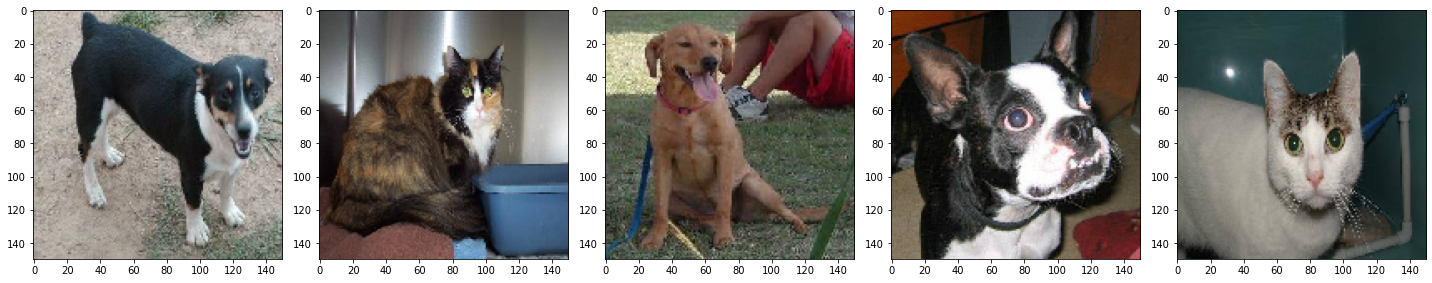

In [78]:
plotImages(sample_training_images[:5])  # Plot images 0-4

# Define the model

In [79]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [80]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model summary

In [81]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 128)      

# Train the model

In [82]:
%%time 

EPOCHS = 100

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    callbacks = my_callbacks,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 11s 543ms/step - loss: 1.3202 - accuracy: 0.4074 - val_loss: 0.7079 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 10s 498ms/step - loss: 0.7017 - accuracy: 0.4976 - val_loss: 0.7044 - val_accuracy: 0.5010
Epoch 3/100
20/20 [==============================] - 10s 496ms/step - loss: 0.6977 - accuracy: 0.5168 - val_loss: 0.6862 - val_accuracy: 0.5570
Epoch 4/100
20/20 [==============================] - 10s 489ms/step - loss: 0.6865 - accuracy: 0.5560 - val_loss: 0.6797 - val_accuracy: 0.5190
Epoch 5/100
20/20 [==============================] - 10s 496ms/step - loss: 0.6741 - accuracy: 0.5866 - val_loss: 0.6365 - val_accuracy: 0.6310
Epoch 6/100
20/20 [==============================] - 10s 488ms/step - loss: 0.6433 - accuracy: 0.6376 - val_loss: 0.6306 - val_accuracy: 0.6750
Epoch 7/100
20/20 [==============================] - 10s 487ms/step - loss: 0.6217 - accuracy: 0.6562 - val_loss: 0.5784 - val_accuracy:

Training accuracy 0.878000020980835
Validation accuracy 0.7689999938011169


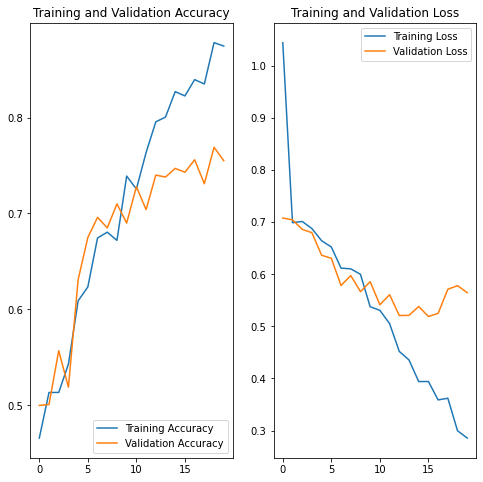

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Training accuracy",max(acc))
print("Validation accuracy",max(val_acc))

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [84]:
ls

foo.png           model.04-0.67.h5  model.07-0.61.h5  model.12-0.57.h5
logs/             model.04-0.68.h5  model.08-0.56.h5  model.13-0.52.h5
model.02-0.66.h5  model.04-0.69.h5  model.08-0.60.h5  model.14-0.52.h5
model.02-0.69.h5  model.05-0.64.h5  model.09-0.57.h5  model.15-0.54.h5
model.02-0.70.h5  model.05-0.65.h5  model.09-0.65.h5  model.16-0.52.h5
model.03-0.66.h5  model.05-0.70.h5  model.10-0.59.h5  model.17-0.53.h5
model.03-0.67.h5  model.06-0.61.h5  model.10-0.61.h5  model.18-0.57.h5
model.03-0.69.h5  model.06-0.63.h5  model.11-0.54.h5  model.19-0.58.h5
model.03-0.70.h5  model.06-0.70.h5  model.11-0.58.h5  model.20-0.56.h5
model.04-0.63.h5  model.07-0.58.h5  model.12-0.56.h5  sample_data/
